In [2]:
import cv2 as cv
import numpy as np
from imutils import contours, resize
from glob import iglob
import matplotlib.pyplot as plt

In [3]:
def cropAndResize(image):
    gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    found = None
    for scale in np.linspace(0.2, 1.0, 20)[::-1]:
        resized = resize(gray, width = int(gray.shape[1] * scale))
        ratio = gray.shape[1] / float(resized.shape[1])
        if resized.shape[0] < tH or resized.shape[1] < tW:
            break
        # resized = cv.GaussianBlur(resized, (5,5), 0)
        edged = cv.Canny(resized, 20, 50)
        result = cv.matchTemplate(edged, template_canny, cv.TM_CCOEFF)

        (_, maxVal, _, maxLoc) = cv.minMaxLoc(result)
        if found is None or maxVal > found[0]:
            found = (maxVal, maxLoc, ratio)

    (_, maxLoc, ratio) = found
    (startX, startY) = (int(maxLoc[0] * ratio), int(maxLoc[1] * ratio))
    (endX, endY) = (int((maxLoc[0] + tW) * ratio), int((maxLoc[1] + tH) * ratio))
    return cv.resize(image[startY:endY, startX:endX], (tW, tH))


In [4]:
def show(images):
    i= 2
    for image in images:
        plt.subplot(3,4,i)
        plt.imshow(image[...,::-1])
        plt.axis('off')
        if i == 2:
            i = 5
        elif i == 8:
            i = 10
        else:
            i += 1

In [5]:
colors = {
    'o': ([3, 50, 60], [18, 255, 255]),     # Orange v
    'g': ([50, 90, 60], [80, 255, 255]),        # Green v
    'r': ([151, 100, 60], [180, 255, 255]),        # red
    'R': ([0, 100, 60], [3, 255, 255]),        # red
    'b': ([80, 90, 70], [150, 255, 255]),    # Blue v
    'y': ([21, 100, 600], [41, 255, 255]),   # Yellow v 
    'w':([0, 0, 100], [180, 70, 255]),        #White v
    }

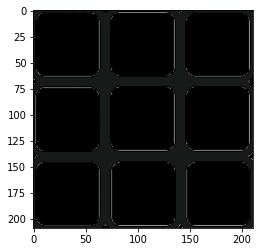

In [6]:
template = cv.imread('template.png')
template_canny = cv.Canny(template, 80, 100)
tH, tW, _ = template.shape
plt.imshow(template)

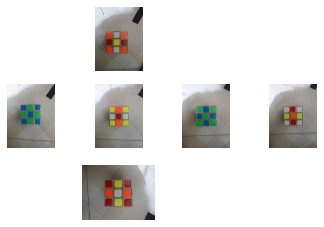

In [7]:
images = []
for filepath in iglob(r'test/3/rub*.jpg', recursive=True):
    image = cv.imread(filepath)
    hsv = cv.cvtColor(image, cv.COLOR_BGR2HSV)
    hsv[:,:,2] += 50
    images.append(image)
show(images)

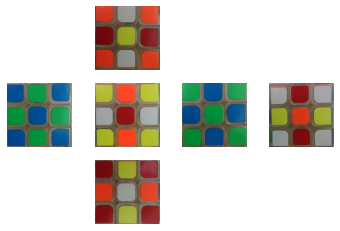

In [8]:
crop_images = []
for image in images:
    crop_img = cropAndResize(image)
    crop_images.append(crop_img)
show(crop_images)

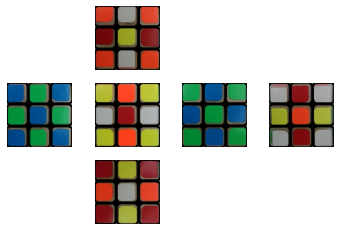

In [13]:
gray_template = cv.cvtColor(template,cv.COLOR_BGR2GRAY)
_, mask = cv.threshold(gray_template, 10, 255, cv.THRESH_BINARY)
mask_inv = cv.bitwise_not(mask)
plt.imshow(mask)
faces = []
for img in crop_images:
    faces.append(cv.bitwise_and(img, img, mask = mask_inv))
show(faces)

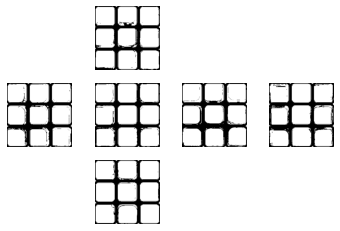

In [16]:
masks = []
faces_hsv = []
for face in faces:
    hsv = cv.cvtColor(face, cv.COLOR_BGR2HSV)
    mask = np.zeros(template.shape, dtype=np.uint8)
    for color, (lower, upper) in colors.items():
        lower = np.array(lower, dtype=np.uint8)
        upper = np.array(upper, dtype=np.uint8) 
        
        color_mask = cv.inRange(hsv, lower, upper)
        # plt.imshow(color_mask)
        color_mask = cv.merge([color_mask, color_mask, color_mask])
        mask = cv.bitwise_or(mask, color_mask)
    masks.append(mask)
    faces_hsv.append(hsv)
show(masks)

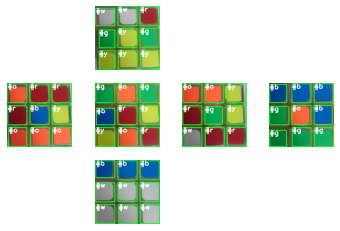

In [134]:
cube = ''
a = 0
for face in faces_hsv:
    #find position
    gray = cv.cvtColor(masks[a], cv.COLOR_BGR2GRAY)
    cnts = cv.findContours(gray, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    cnts = cnts[0] if len(cnts) == 2 else cnts[1]

    # Sort all contours from area, top-to-bottom and left-to-right
    cnts = sorted(cnts, key=cv.contourArea, reverse=True)
    cnts = cnts[:9]
    (cnts, _) = contours.sort_contours(cnts, method="top-to-bottom")

    cube_rows = []
    row = []
    for (i, c) in enumerate(cnts, 1):
        row.append(c)
        if i % 3 == 0:  
            (cnts, _) = contours.sort_contours(row, method="left-to-right")
            cube_rows.append(cnts)
            row = []
    
    # Draw text
    for row in cube_rows:
        for c in row:
            x,y,w,h = cv.boundingRect(c)
            for color, (lower, upper) in colors.items():
                lower = np.array(lower, dtype=np.uint8)
                upper = np.array(upper, dtype=np.uint8)

                color_check = face[int(y+h/2)][int(x+w/2)]
                check = True
                for i in range(3):
                    if color_check[i] not in range(lower[i], upper[i]+1):
                        check = False
                        break
                if check == True:   
                    cv.rectangle(crop_images[a], (x, y), (x + w, y + h), (36,255,12), 2)
                    cv.putText(crop_images[a], "#{}".format(color), (x, y + 15), cv.FONT_HERSHEY_SIMPLEX, 0.7, (255,255,255), 2)
                    cube += str(color).lower()
                    break
    a += 1
show(crop_images)

In [135]:
from rubik_solver import utils

In [136]:
utils.pprint(cube)

                   | --- | --- | --- |
                   |     |     |     |
                   | --- | --- | --- |
                   |     |     |     |
                   | --- | --- | --- |
                   |     |     |     |
                   | --- | --- | --- |
| --- | --- | --- | | --- | --- | --- | | --- | --- | --- | | --- | --- | --- | 
|     |     |     | |     |     |     | |     |     |     | |     |     |     | 
| --- | --- | --- | | --- | --- | --- | | --- | --- | --- | | --- | --- | --- | 
|     |     |     | |     |     |     | |     |     |     | |     |     |     | 
| --- | --- | --- | | --- | --- | --- | | --- | --- | --- | | --- | --- | --- | 
|     |     |     | |     |     |     | |     |     |     | |     |     |     | 
| --- | --- | --- | | --- | --- | --- | | --- | --- | --- | | --- | --- | --- | 
                   | --- | --- | --- |
                   |     |     |     |
                   | --- | --- | --- |
                   |     |     |     |
    

In [140]:
print(utils.solve(cube, 'Kociemba'))

[R2, L, D2, L2, B', U, D, B', U2, L', F, U, L2, U, F2, L2, U', B2, D', B2, D]
